In [20]:
%matplotlib inline
%run ../../import_envs.py
# %run ../apg_hyperparams_v3.py
%run ../apg_hyperparams.py
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')

probtorch: 0.0+5a2c637 torch: 1.3.0
inference method:apg, apg sweeps:9, epochs:200, sample size:10, batch size:20, learning rate:0.0005


In [21]:
# load test data
# test_sets = ['pts_120', 'pts_160', 'pts_200', 'pts_400', 'pts_600']
test_sets = ['pts_600']

DATAs = []
for s in test_sets:
    data = torch.from_numpy(np.load(DATA_DIR + 'dgmm/test/' + s + '/' + 'ob.npy')).float() ## load testing datasets
    DATAs.append(data)
## load the weights
from apg_modeling import init_model

model = init_model(model_params=model_params, 
                    CUDA=CUDA, 
                    DEVICE=DEVICE, 
                    LOAD_VERSION=LOAD_VERSION,
                    LR=None)


<Figure size 432x288 with 0 Axes>

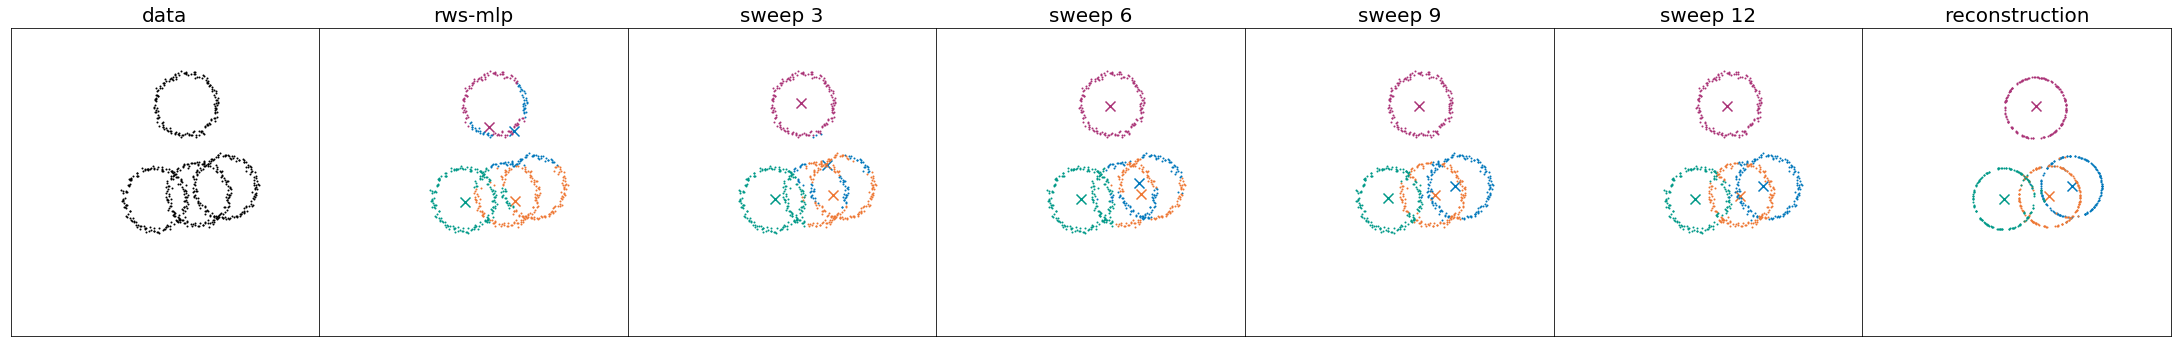

In [58]:
SAMPLE_SIZE_TEST = 1
from resample import Resampler
resampler = Resampler(strategy=RESAMPLING_STRATEGY,
                      sample_size=SAMPLE_SIZE_TEST,
                      CUDA=CUDA, 
                      DEVICE=DEVICE)


## visualize samples
%run ../apg_testing.py
from viz import viz_samples

APG_SWEEPS_TEST = 12
DATA_PTR = 118


SAVE_NAME = 'samples-%d' % DATA_PTR

datas = sample_data_uniform(DATAs=DATAs, 
                            data_ptr=DATA_PTR)

metrics = test_single(model=model, 
                      resampler=resampler,
                      apg_sweeps=APG_SWEEPS_TEST, 
                      datas=datas, 
                      K=K,
                      sample_size=SAMPLE_SIZE_TEST,
                      CUDA=CUDA, 
                      DEVICE=DEVICE)



In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
"""
==========
visualization functions
==========
"""
def viz_dgmm(ax, ob, K, mu_marker_size, marker_size, opacity, bound, colors, latents=None):
    if latents == None:
        ax.scatter(ob[:, 0], ob[:, 1], c='k', s=marker_size, zorder=3)
    else:
        (mu, z) = latents
        assignments = z.argmax(-1)
        for k in range(K):
            ob_k = ob[np.where(assignments == k)]
            ax.scatter(ob_k[:, 0], ob_k[:, 1], c=colors[k], s=marker_size, alpha=opacity, zorder=3)
            ax.scatter(mu[k, 0], mu[k, 1], marker='P',linewidths=1.0, s=mu_marker_size, c=colors[k])
    ax.set_ylim([-3.5, 7.5])
    ax.set_xlim([-4, 7])
    ax.set_xticks([])
    ax.set_yticks([])




def viz_samples(datas, metrics, apg_sweeps, K, viz_interval, figure_size, title_fontsize, mu_marker_size, marker_size, opacity, bound, colors, save_name=None):
    """
    ==========
    visualize the samples along the sweeps
    ==========
    """
    num_rows = len(datas)
    num_cols = 3 + int(apg_sweeps / viz_interval)
    gs = gridspec.GridSpec(num_rows, num_cols)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(figure_size, figure_size * num_rows / num_cols))
    for row_ind, data in enumerate(datas):
        E_mu = metrics[row_ind]['E_mu'].cpu()
        E_z = metrics[row_ind]['E_z'].cpu()
        recon = metrics[row_ind]['E_recon'].cpu()
        ax = fig.add_subplot(gs[row_ind, 0])

        viz_dgmm(ax=ax,
                 ob=data,
                 K=K,
                 mu_marker_size=mu_marker_size,
                 marker_size=marker_size,
                 opacity=opacity,
                 bound=bound,
                 colors=colors,
                 latents=None)
        if row_ind == 0:
            ax.set_title('data', fontsize=title_fontsize)
        for i in range(num_cols-1):
            ax = fig.add_subplot(gs[row_ind, i+1])
            if i == num_cols - 2:
                viz_dgmm(ax=ax,
                         ob=recon[-1, 0],
                         K=K,
                         mu_marker_size=mu_marker_size,
                         marker_size=marker_size,
                         opacity=opacity,
                         bound=bound,
                         colors=colors,
                         latents=(E_mu[-1, 0], E_z[-1, 0]))
            else:
                sweep = i * viz_interval
                viz_dgmm(ax=ax,
                         ob=data,
                         K=K,
                         mu_marker_size=mu_marker_size,
                         marker_size=marker_size,
                         opacity=opacity,
                         bound=bound,
                         colors=colors,
                         latents=(E_mu[sweep, 0], E_z[sweep, 0]))
            if row_ind == 0:
                if i == 0:
                    ax.set_title('rws-mlp', fontsize=title_fontsize)
                elif i == num_cols-2:
                    ax.set_title('reconstruction', fontsize=title_fontsize)
                else:
                    ax.set_title('sweep %d' % sweep, fontsize=title_fontsize)


    if save_name is not None:
        plt.savefig(save_name +'.svg', dpi=300)


def Plot_metrics(ll, ess, sample_size, filename):
    num_cols = len(ll)
    gs = gridspec.GridSpec(2, num_cols)
    gs.update(left=0.05 , bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.05)
    fig = plt.figure(figsize=(self.fs, self.fs * 2 / num_cols))
    plt.rc('axes',edgecolor='#eeeeee')
    for col_ind in range(num_cols):
        ax1 = fig.add_subplot(gs[0, col_ind])
        ax2 = fig.add_subplot(gs[1, col_ind])
        temp = ll[col_ind][0].data.numpy()

        baseline = np.ones(temp.shape[0]) * temp[0]
        ax1.plot(ll[col_ind][0].data.numpy(), c=self.colors[0], marker='o')
        ax1.plot(baseline, '--', c=self.colors[1], alpha=0.4)

        ax2.plot(ess[col_ind][0].data.numpy() / sample_size, c=self.colors[2])
        ax2.scatter(np.arange(temp.shape[0]), ess[col_ind][0].data.numpy() / sample_size, c=self.colors[2], s=6.0)

        # ax1.set_title('N= %d' % ((col_ind+1) * 20), fontsize=self.title_fontsize)
        # if col_ind == 0:
            # ax1.set_ylabel('log p(z, x)', fontsize=self.title_fontsize)
            # ax2.set_ylabel('ESS / L', fontsize=self.title_fontsize)
        ax2.set_ylim([-0.1, 1.1])
        ax1.set_xticks([])
        ax1.set_ylim([temp.min()-50, temp.max()+10])
    plt.savefig(filename + '.svg', dpi=300)
    plt.savefig(filename + '.pdf')


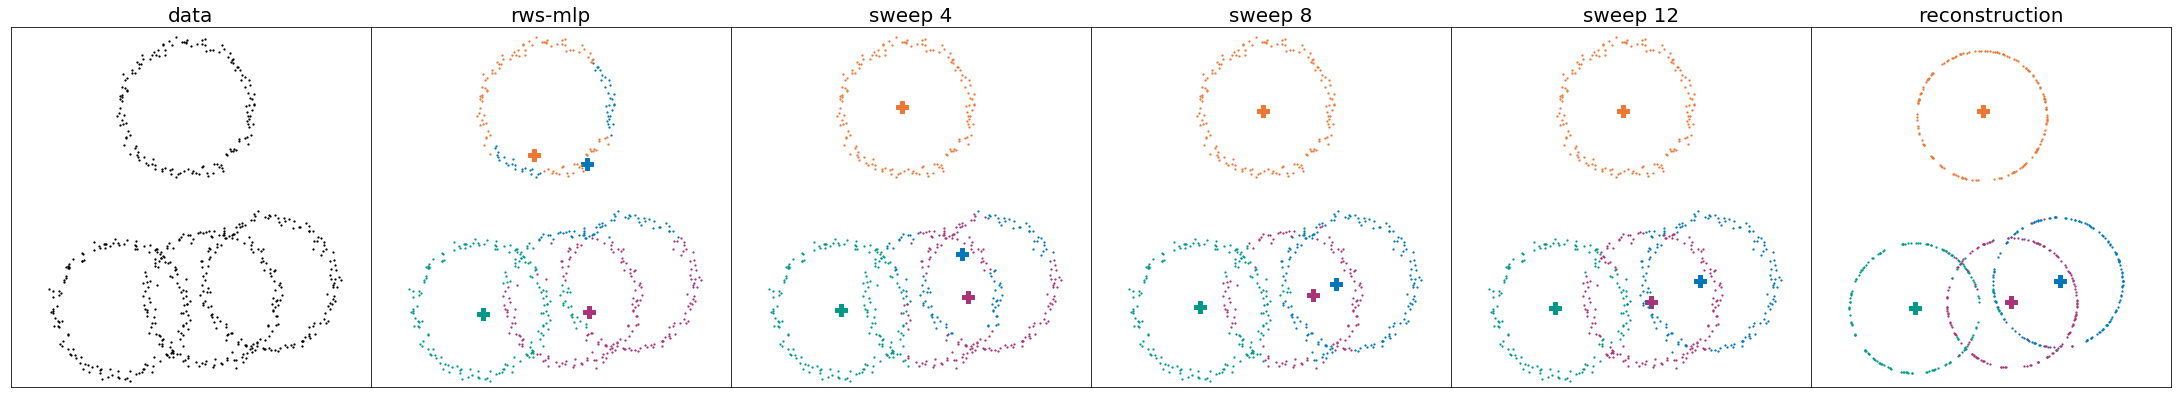

In [98]:

viz_samples(datas=datas,
            metrics=metrics,
            apg_sweeps=APG_SWEEPS_TEST,
            K=K, 
            viz_interval=4, 
            figure_size=30, 
            title_fontsize=20, 
            mu_marker_size=150,
            marker_size=1.5, 
            opacity=1.0, 
            bound=10, 
            colors=['#0077BB',  '#EE7733', '#AA3377', '#009988', '#BBBBBB', '#EE3377', '#DDCC77'],
            save_name=SAVE_NAME)

In [12]:


# apg_sweeps = [1, 2, 5, 10 , 20]
# sample_sizes = [100, 50, 20, 10, 5]
datas = sample_data_uniform(DATAs=DATAs, 
                            data_ptr=DATA_PTR)
ob = datas[0]
ess, density = test_budget_grid(model=model,
                                apg_sweeps=apg_sweeps,
                                sample_sizes=sample_sizes,
                                data=ob.unsqueeze(0),
                                K=K,
                                CUDA=CUDA,
                                DEVICE=DEVICE)

ess = torch.Tensor(ess).cpu()
density = torch.Tensor(density).cpu()

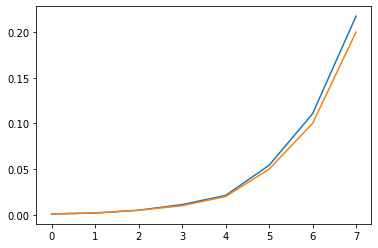

In [13]:
import matplotlib.pyplot as plt
ss = torch.Tensor(sample_sizes)
baselines = 1. / np.array(sample_sizes)
plt.plot(ess)
plt.plot(baselines)

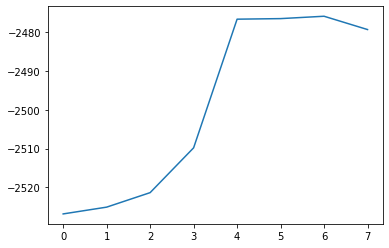

In [14]:
plt.plot(density)

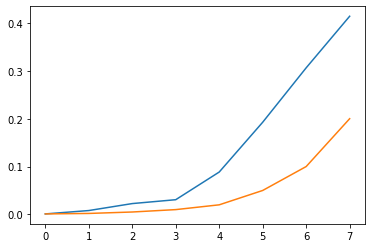

In [18]:
%run ../apg_testing.py
ob = datas[0]
apg_sweeps = [1, 2, 5, 10 , 20 , 50, 100, 200]
sample_sizes = [1000, 500, 200, 100, 50, 20, 10, 5]
ess, density = test_budget_grid(model=model,
                                apg_sweeps=apg_sweeps,
                                sample_sizes=sample_sizes,
                                data=ob.unsqueeze(0),
                                K=K,
                                CUDA=CUDA,
                                DEVICE=DEVICE)

ess = torch.Tensor(ess).cpu()
density = torch.Tensor(density).cpu()
baselines = 1. / np.array(sample_sizes)
plt.plot(ess)
plt.plot(baselines)

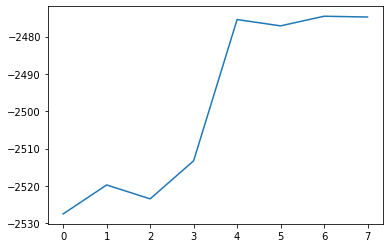

In [19]:
plt.plot(density)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(final.mean(0), cmap='inferno', vmin=-2100, vmax=-1370)



apg_sweeps_ticks = ['K=1', 'K=2', 'K=5', 'K=10', 'K=20' , "K=50", 'K=100', 'K=200']
sample_sizes_ticks = ['L=1000', 'L=500', 'L=200', 'L=100', 'L=50', 'L=20', 'L=10', 'L=5']

# We want to show all ticks...
ax.set_xticks(np.arange(len(apg_sweeps)))
ax.set_yticks(np.arange(len(sample_sizes)))
# ... and label them with the respective list entries
ax.set_xticklabels(apg_sweeps_ticks, fontsize=18)
ax.set_yticklabels(sample_sizes_ticks, fontsize=18)

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(apg_sweeps)):
    for j in range(len(apg_sweeps)):
        text = ax.text(j, i, round(final.mean(0)[i, j], 4),
                       ha="center", va="center", color='black', fontsize=20)
# plt.savefig('heatmap_log_joint_dgmm.svg', dpi=300)

In [ ]:
import numpy as np
a = np.load('heatmap_ess_dgmm.npy')
np.diagonal(a.mean(0))

In [ ]:

pts = [200, 400, 600]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(baseline, 'k:', label='baseline', lw=5)
for i in range(ESSs_cpu.shape[1]):
    ess = ESSs_cpu[:, i]
    plt.plot(ess, 'o-', label='N=%d' % pts[i])
    ax.legend()
#     ax.set_yscale('log')
#     ax.set_ylim([1e-3, 1.0])

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in range(DENSITIES_cpu.shape[1]):
    density = DENSITIES_cpu[:, i]
    plt.plot(density, 'o-', label='N=%d' % pts[i])
    ax.legend()
#     ax.set_ylim([-1000, -200])